In [89]:
import numpy as np
import pandas as pd
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from random import randrange
import shap
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import dalex as dx
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import string
from sklearn.metrics import precision_score
from scipy.stats import chisquare
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression


# Civil Comments

In [2]:
#splitting our dataset and setting labels
data = pd.read_csv("data.csv")
np.random.seed(0)
comments = data["comment_text"]
target = (data["target"]>0.7).astype(int)

comments_train, comments_test, y_train, y_test = train_test_split(comments, target, test_size=0.30, stratify=target)

print(y_train.value_counts())
print(y_test.value_counts())

1    31816
0    31815
Name: target, dtype: int64
0    13636
1    13635
Name: target, dtype: int64


In [3]:
# Get vocabulary from training data
vectorizer = CountVectorizer()
vectorizer.fit(comments_train)

# Get word counts for training and test sets
X_train = vectorizer.transform(comments_train)
X_test = vectorizer.transform(comments_test)

# Preview the dataset
print("Data successfully loaded!\n")
print("Sample toxic comment:", comments_train.iloc[22])
print("Sample not-toxic comment:", comments_train.iloc[17])

Data successfully loaded!

Sample toxic comment: Too dumb to even answer.
Sample not-toxic comment: No they aren't.


In [7]:
#train logistic regression
classifier = LogisticRegression(max_iter=2000)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.9304755967877966


In [8]:
preds = classifier.predict(X_test)
X_c_test = pd.DataFrame(comments_test.copy())
X_c_test['comment_text'] = X_c_test['comment_text'].str.lower()
X_c_test['t'] = y_test
X_c_test['p'] = list(preds)
X_c_test.head()

,comment_text,t,p
38571,never underestimate the babbling ignorance of ...,1,1
23860,damn. got to revert back to cash only,1,1
21735,"if laughing at useless rich kids is wrong, i d...",1,1
79392,extremism exists on both sides of the debate. ...,0,0
53739,it has been quite pityful to read some of the ...,0,0


In [24]:
christest = X_c_test[X_c_test.comment_text.str.contains('christian')]
mustest = X_c_test[X_c_test.comment_text.str.contains('muslim')]

In [25]:
religion_df = christest.append(mustest)
ddd = religion_df[(religion_df.comment_text.str.contains("christian"))&(religion_df.comment_text.str.contains("muslim"))].index
religion_df = religion_df.drop(ddd,axis=0)

In [26]:
christest = religion_df[religion_df.comment_text.str.contains('christian')]
mustest = religion_df[religion_df.comment_text.str.contains('muslim')]

In [27]:
print("There are", len(christest), "comments containing the word 'christian'")
print("There are", len(mustest), "comments containing the word 'muslim'")

There are 190 comments containing the word 'christian'
There are 289 comments containing the word 'muslim'


In [28]:
cpr = christest.p.value_counts()/christest.p.value_counts().sum()
mpr = mustest.p.value_counts()/mustest.p.value_counts().sum()
print(cpr,mpr)

0    0.505263
1    0.494737
Name: p, dtype: float64 1    0.733564
0    0.266436
Name: p, dtype: float64


In [29]:
religion_df['religion']=np.where(religion_df.comment_text.str.contains("christian"),1,0)
religion_df

,comment_text,t,p,religion
40267,<<how many male fashion designers are straight...,1,0,1
4148,why don't pc fascist like yourself not go and ...,1,1,1
9962,when are the geniuses in the leftist media goi...,1,1,1
79421,wow. so people are supposed to be forced to s...,0,0,1
81196,although members of the kkk swear to uphold ch...,0,0,1
...,...,...,...,...
15408,"not all muslims are terrorists, but all terror...",1,1,0
58324,guess the world’s reaction to 9/11 and paris w...,0,0,0
17308,trump is a total buffoon he is opening a can o...,1,1,0
24268,the chump has some nerve. he never apologizes ...,1,1,0


In [30]:
contigency_p = pd.crosstab(religion_df['religion'], religion_df['p']) 
cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
contigency_pct_p = pd.crosstab(religion_df['religion'], religion_df['p'], normalize='index')
print(pp)
contigency_pct_p

1.72999753944881e-07


p,0,1
religion,,
0,0.266436,0.733564
1,0.505263,0.494737


In [31]:

contigency_p = pd.crosstab(religion_df['religion'], religion_df['t']) 
cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
contigency_pct_p = pd.crosstab(religion_df['religion'], religion_df['t'], normalize='index')
print(pp)
contigency_pct_p

5.471457660271159e-07


t,0,1
religion,,
0,0.252595,0.747405
1,0.478947,0.521053


In [32]:
tnc, fpc, fnc, tpc = confusion_matrix(list(christest['t']), list(christest['p']), labels=[0, 1]).ravel()

In [33]:
tnm, fpm, fnm, tpm = confusion_matrix(list(mustest['t']), list(mustest['p']), labels=[0, 1]).ravel()

In [34]:
print("True Positive Rate for comments containing 'christian'",(tpc/(tpc+fnc))*100,'%')
print("True Positive Rate for comments containing 'muslim'",(tpm/(tpm+fnm))*100,'%\n')
tprc = (tpc/(tpc+fnc))
print(tpm/(tpm+fnm))
tprm = (tpm/(tpm+fnm))
from sklearn.metrics import recall_score
recall_score(christest['t'],christest['p'])
chisquare([tprc*100,tprm*100])[1]

True Positive Rate for comments containing 'christian' 87.87878787878788 %
True Positive Rate for comments containing 'muslim' 88.42592592592592 %

0.8842592592592593


0.9671313303697889

In [35]:
print("False Positive Rate for comments containing 'christian'",(fpc/(fpc+tnc))*100,'%')
print("False Positive Rate for comments containing 'muslim'",(fpm/(fpm+tnm))*100,'%\n')
fprc = (fpc/(fpc+tnc))
fprm = (fpm/(fpc+tnm))
#from sklearn.metrics import recall_score
#recall_score(christest['t'],christest['p'])
chisquare([fprc*100,fprm*100])[1]

False Positive Rate for comments containing 'christian' 7.6923076923076925 %
False Positive Rate for comments containing 'muslim' 28.767123287671232 %



2.227317172825575e-05

In [36]:
print("True Negative Rate for comments containing 'christian'",(1-fprc)*100,'%')
print("True Negative Rate for comments containing 'muslim'",(1-fprm)*100,'%\n')
tnrc = (1-fprc)*100
tnrm = (1-fprm)*100
#from sklearn.metrics import recall_score
#recall_score(christest['t'],christest['p'])
chisquare([tnrc,tnrm])[1]

True Negative Rate for comments containing 'christian' 92.3076923076923 %
True Negative Rate for comments containing 'muslim' 64.40677966101696 %



0.025829688856548086

In [37]:
print("False Negative Rate for comments containing 'christian'",(1-tprc)*100,'%')
print("False Negative Rate for comments containing 'muslim'",(1-tprm)*100,'%\n')
fnrc = (1-tprc)*100
fnrm = (1-tprm)*100
#from sklearn.metrics import recall_score
#recall_score(christest['t'],christest['p'])
chisquare([12.12121212,11.57407407])[1]

False Negative Rate for comments containing 'christian' 12.121212121212121 %
False Negative Rate for comments containing 'muslim' 11.574074074074069 %



0.9105063317011339

In [38]:
psc = precision_score(christest['t'],christest['p'])*100
psm = precision_score(mustest['t'],mustest['p'])*100
print("Precision of comments containing 'Christian':",psc,"%")
print("Precision of comments containing 'Christian':",psm,"%")

chisquare([psc,psm])[1]

Precision of comments containing 'Christian': 92.5531914893617 %
Precision of comments containing 'Christian': 90.09433962264151 %


0.8556307097573211

In [41]:
coefficients = pd.DataFrame({"word": sorted(list(vectorizer.vocabulary_.keys())), "coeff": classifier.coef_[0]})
coefficients.sort_values(by='coeff',ascending=False).head(10)

,word,coeff
49789,stupid,9.279042
25847,idiot,8.605627
25858,idiots,8.602676
49802,stupidity,7.554271
25850,idiotic,7.005563
38317,pathetic,6.554688
12907,crap,6.490016
16844,dumb,6.359579
34211,moron,6.333128
20745,fools,6.279325


In [42]:
coefficients[(coefficients.word == 'black') |( coefficients.word == 'white') | (coefficients.word == 'male') | (coefficients.word == 'female')
            | (coefficients.word == 'muslim') | (coefficients.word == 'christian')
            ].sort_values('coeff',ascending=False)


,word,coeff
6893,black,2.104713
34692,muslim,1.768671
56554,white,1.169230
31827,male,0.342602
19861,female,0.158072
10293,christian,-0.041078


In [43]:
coefflist = []
#ddf3 = ddf2[ddf2.target==1]
a_string = mustest.sample(len(mustest))['comment_text']
for i in a_string:
    new_string = i.translate(str.maketrans('', '', string.punctuation))
    filtered_sentence = remove_stopwords(new_string.lower())
    word_c_list = {}
    for j in filtered_sentence.split(" "):
        if j in list(coefficients.word):
            word_c_list[j] = coefficients[coefficients.word == j.lower()].coeff.iloc[0]

    coefflist.append(sum(word_c_list.values()))
    
coefflist

[1.0247279499709738,
 14.086832842990361,
 1.5846205811831235,
 10.862492030363923,
 3.210678167395913,
 5.74027095089448,
 8.20664364551536,
 -2.6641231102605443,
 0.9048168354449476,
 3.7682447124491185,
 9.617051755977942,
 12.582058055602364,
 3.8540854063421004,
 9.879480501599865,
 2.709964358531116,
 3.248752026908073,
 16.76712891410371,
 6.844197590740532,
 7.255084022028963,
 2.189731262748868,
 2.334433185379306,
 18.82485218045499,
 13.846998265391228,
 1.0186579453498847,
 2.0595750151599024,
 4.4232284442285765,
 5.209568989997472,
 11.400400772639827,
 -4.850020849170256,
 0.7039652952955109,
 0.558129234908377,
 11.635091785340217,
 9.981509300062525,
 3.2273867401730763,
 9.730740803388251,
 15.653530478768625,
 11.267048941975506,
 -1.3122037714038506,
 0.6818598309076089,
 6.407121105092069,
 1.738420535739017,
 4.100686058394339,
 0.38164220689617456,
 -0.508168277436713,
 10.93616287449038,
 3.1985836754339245,
 10.5123523050663,
 1.9866944899869556,
 -5.6378411670

In [47]:
coefflist2 = []
a_string = christest.sample(len(christest))['comment_text']
for i in a_string:
    new_string = i.translate(str.maketrans('', '', string.punctuation))
    filtered_sentence = remove_stopwords(new_string.lower())
    word_c_list = {}
    for j in filtered_sentence.split(" "):
        if j in list(coefficients.word):
            word_c_list[j] = coefficients[coefficients.word == j.lower()].coeff.iloc[0]

    coefflist2.append(sum(word_c_list.values()))
    
coefflist2

[-0.6338612240769961,
 2.222683942059685,
 -0.27088576113302176,
 -1.9875452410081738,
 0.9606194734649429,
 18.676232087758127,
 5.152886184607137,
 1.0113788228475986,
 0.8152921398187383,
 -1.5642798953968273,
 11.756991441226825,
 -1.965576131261189,
 17.477894207822455,
 0.08254405912701723,
 7.686613706301281,
 21.828825584186426,
 -2.907647066340711,
 7.00978647091734,
 4.3565221085973755,
 10.485587799092986,
 14.685354758063657,
 -1.3454324256495254,
 -0.2723182619935599,
 11.352599079553405,
 8.256632798507823,
 0.8168914839061021,
 -3.6133304055333677,
 3.6539447993710183,
 3.59207183846065,
 3.5247508910157377,
 3.365992684394358,
 2.639041391835055,
 11.218870027677816,
 7.359970442075042,
 8.033825743721547,
 1.631144389879513,
 1.6687132146315056,
 -3.3570430571765217,
 -0.7708875368831813,
 3.467064276694821,
 2.4134254775901116,
 6.895120494381481,
 7.665653813229831,
 5.654530659748719,
 17.806551496320917,
 -1.370102451783623,
 -1.27845587438525,
 30.370872553825,
 0

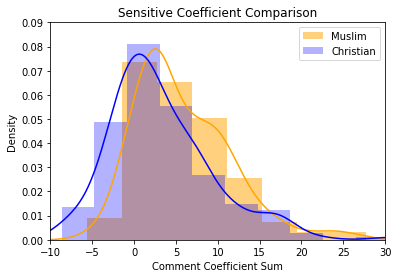

In [48]:
fig, ax = plt.subplots(figsize = (6,4))

muslim_plot = pd.Series(coefflist)
christian_plot = pd.Series(coefflist2)
    # Plot histogram
muslim_plot.plot(kind = "hist", density = True,alpha=0.5,color='orange',label='Muslim') # change density to true, because KDE uses density
    # Plot KDE
muslim_plot.plot(kind = "kde",label='_nolegend_',color='orange')
christian_plot.plot(kind = "hist", density = True,alpha=0.3,color='blue',label='Christian') # change density to true, because KDE uses density
    # Plot KDE
christian_plot.plot(kind = "kde",label='_nolegend_',color='blue')

# X #
ax.set_xlabel("Comment Coefficient Sum")

# Y #
ax.set_ylim(0, 0.09)
ax.set_xlim(-10, 30)

# Overall #
ax.set_title("Sensitive Coefficient Comparison")
plt.legend(loc='upper right')

plt.show()

# German Credit

In [49]:
data = dx.datasets.load_german()
data[['credit_amount','duration','age']].describe()

,credit_amount,duration,age
count,1000.000000,1000.000000,1000.000000
mean,3271.258000,20.903000,35.546000
std,2822.736876,12.058814,11.375469
min,250.000000,4.000000,19.000000
25%,1365.500000,12.000000,27.000000
50%,2319.500000,18.000000,33.000000
75%,3972.250000,24.000000,42.000000
max,18424.000000,72.000000,75.000000


In [50]:
data.describe()
data.drop(['credit_amount','duration','age'],axis=1).astype('object').describe()

,risk,sex,job,housing,saving_accounts,checking_account,purpose
count,1000,1000,1000,1000,1000,1000,1000
unique,2,2,4,3,5,4,8
top,1,male,2,own,little,not_known,car
freq,700,690,630,713,603,394,337


In [52]:
le = preprocessing.LabelEncoder()
data['sex']=le.fit_transform(data.sex)
data['housing']=le.fit_transform(data.housing)
data['saving_accounts']=le.fit_transform(data.saving_accounts)
data['checking_account']=le.fit_transform(data.checking_account)
data['purpose']=le.fit_transform(data.purpose)

data.head()

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age
0,1,1,2,1,2,0,1169,6,5,67
1,0,0,2,1,0,1,5951,48,5,22
2,1,1,1,1,0,2,2096,12,3,49
3,1,1,2,0,0,0,7882,42,4,45
4,0,1,2,0,0,0,4870,24,1,53


In [54]:
X = data.drop(["risk"], axis=1)
y = data["risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Data successfully loaded!\n")

Data successfully loaded!



In [55]:
model = xgboost.XGBClassifier().fit(X_train, y_train)

predict = model.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
preds = model.predict(X_test)
preds

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1])

In [58]:
fd = X_test.copy()
preds = model.predict(X_test)
fd['p'] = preds
fd['t'] = y_test
atest = fd[fd.sex==0]
btest = fd[fd.sex==1]
atest

,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age,p,t
27,0,2,2,4,3,409,12,5,42,1,1
306,0,1,2,2,2,4811,30,1,24,1,1
175,0,3,1,2,2,7485,30,1,53,1,0
14,0,2,2,0,0,1403,15,1,28,1,1
883,0,0,1,0,2,1098,18,5,65,1,1
...,...,...,...,...,...,...,...,...,...,...,...
458,0,2,1,0,0,343,6,2,27,0,1
834,0,1,1,0,3,2327,15,5,25,1,0
679,0,2,1,0,2,1453,18,5,26,1,1
722,0,1,1,0,0,1228,12,1,24,0,0


In [59]:
contigency_p = pd.crosstab(fd['sex'], fd['p']) 
cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
contigency_pct_p = pd.crosstab(fd['sex'], fd['p'], normalize='index')
print(pp)
contigency_pct_p

0.8225708911826695


p,0,1
sex,,
0,0.194444,0.805556
1,0.218750,0.781250


In [60]:
contigency_p = pd.crosstab(fd['sex'], fd['t']) 
cp, pp, dofp, expectedp = chi2_contingency(contigency_p) 
contigency_pct_p = pd.crosstab(fd['sex'], fd['t'], normalize='index')
print(pp)
contigency_pct_p

0.23990131169226664


t,0,1
sex,,
0,0.347222,0.652778
1,0.257812,0.742188


In [63]:
tnm, fpm, fnm, tpm = confusion_matrix(list(atest['t']), list(atest['p']), labels=[0, 1]).ravel()
tnf, fpf, fnf, tpf = confusion_matrix(list(btest['t']), list(btest['p']), labels=[0, 1]).ravel()

In [64]:
print("True Positive Rate for Group A",(tpm/(tpm+fnm))*100,'%')
print("True Positive Rate for Group B",(tpf/(tpf+fnf))*100,'%\n')
tprm = (tpm/(tpm+fnm))
tprf = (tpf/(tpf+fnf))
from sklearn.metrics import recall_score
recall_score(atest['t'],atest['p'])

chisquare([tprm*100,tprf*100])[1]

True Positive Rate for Group A 95.74468085106383 %
True Positive Rate for Group B 85.26315789473684 %



0.43593930807521697

In [65]:
print("False Positive Rate for Group A",(fpm/(fpm+tnm))*100,'%')
print("False Positive Rate for Group B",(fpf/(fpf+tnf))*100,'%\n')
fprm = (fpm/(fpm+tnm))
fprf = (fpf/(fpf+tnf))
chisquare([fprm*100,fprf*100])[1]

False Positive Rate for Group A 52.0 %
False Positive Rate for Group B 57.57575757575758 %



0.5942718834339058

In [66]:
print("True Negative Rate for Group A",(tnm/(tnm+fpm))*100,'%')
print("True Negative Rate for Group B",(tnf/(tnf+fpf))*100,'%\n')
tnrm = (tnm/(tnm+fpm))
tnrf = (tnf/(tnf+fpf))
chisquare([tnrm*100,tnrf*100])[1]

True Negative Rate for Group A 48.0 %
True Negative Rate for Group B 42.42424242424242 %



0.5576362423438422

In [67]:
print("False Negative Rate for Group A",(fnm/(fnm+tpm))*100,'%')
print("False Negative Rate for Group B",(fnf/(fnf+tpf))*100,'%\n')
fprm = (fnm/(fnm+tpm))
fprf = (fnf/(fnf+tpf))
chisquare([fprm*100,fprf*100])[1]

False Negative Rate for Group A 4.25531914893617 %
False Negative Rate for Group B 14.736842105263156 %



0.016167046868271227

In [68]:
psc = precision_score(atest['t'],atest['p'])*100
psm = precision_score(btest['t'],btest['p'])*100
print("Precision for Group A:",psc,"%")
print("Precision for Group B:",psm,"%")

chisquare([psc,psm])[1]

Precision for Group A: 77.58620689655173 %
Precision for Group B: 81.0 %


0.786326136425535

In [72]:
def group_labeler(X_test,sensative):
    sensative_label = {}
    for i in set(X_test[sensative]):
        text = "Please Enter Label for Group" +" "+ str(i)+": "
        label = input(text)
        sensative_label[i]=label
    return(sensative_label)
labels = group_labeler(X_test,'sex')

Please Enter Label for Group 0: Female
Please Enter Label for Group 1: Male


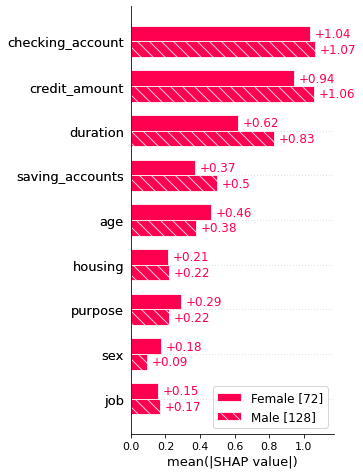

In [73]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
sens_glob_coh = np.where(X_test['sex']==list(labels.keys())[0],labels[0],labels[1])

shap.plots.bar(shap_values.cohorts(sens_glob_coh).abs.mean(0),show=False)

In [79]:
misc = fd[fd.p!=fd.t]
misc = misc.drop(['p','t'],axis=1)
misc

,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age
993,1,3,1,0,0,3959,36,4,30
558,1,2,1,0,0,3552,24,4,27
784,1,3,1,2,1,6468,20,1,60
578,1,2,1,0,1,2820,36,1,27
175,0,3,1,2,2,7485,30,1,53
77,1,2,1,0,1,4771,11,5,51
481,1,2,1,0,1,1201,24,1,26
614,0,2,1,0,2,1808,18,4,22
918,1,2,1,1,0,2359,24,4,33
230,1,2,1,0,3,4210,36,5,26


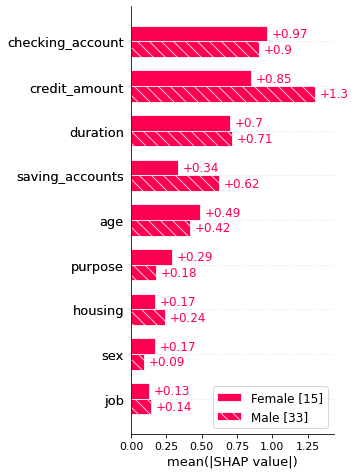

In [81]:
explainer = shap.Explainer(model)
shap_values = explainer(misc)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
sens_glob_coh = np.where(misc['sex']==list(labels.keys())[0],labels[0],labels[1])

shap.plots.bar(shap_values.cohorts(sens_glob_coh).abs.mean(0),show=False)

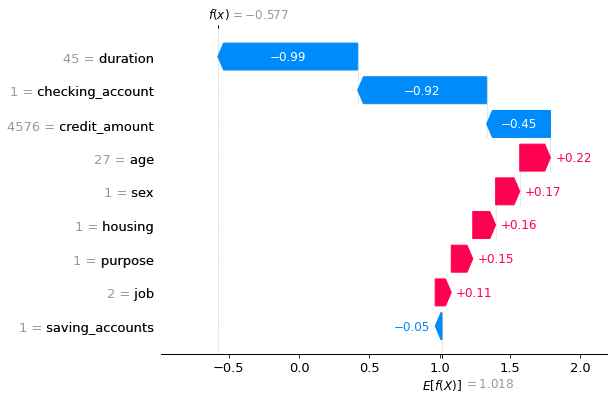

In [84]:
shap.plots.waterfall(explainer(misc)[randrange(0, len(misc))],show=False)

# Credit Card Approval

In [85]:
data = pd.read_csv('synthetic_credit_card_approval.csv')
data.head()

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1


In [86]:
X = data.drop(["Target"], axis=1)
y = data["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Data successfully loaded!\n")

Data successfully loaded!



In [87]:
#Creating simple neural network
model = Sequential()
model.add(Dense(4, input_dim=5, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2022-05-06 09:11:18.819372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=20)


In [ ]:
sub_sampled_train_data = shap.sample(X_train, 100, random_state=0) # use x samples of train data as background data

explainer = shap.KernelExplainer(model.predict,sub_sampled_train_data)


In [ ]:
shap_values = explainer.shap_values(X_test,nsamples=100)


In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)